In [1]:
# Import all required packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from scipy.stats import randint,uniform
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, average_precision_score,precision_recall_curve,auc
import seaborn as sn
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree  import DecisionTreeClassifier
import warnings

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline,set_config
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, precision_score, \
    average_precision_score, auc, precision_recall_curve, make_scorer,SCORERS
from skopt import BayesSearchCV
import datetime, re, sys, holidays
import CommonFunctions
from Functions import *
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm  import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from importlib import reload

set_config(display="diagram")
np.random.seed (0)
Parallel(n_jobs=8, max_nbytes=50000)

warnings.filterwarnings("ignore")

c:\users\rawwi\onedrive\school\nus\current sem\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
categorical_cols = ['Vessel Type']
vessel_cols = ['Total Vessels (Number)', 'Capesize',
                'Capesize Laden', 'Capesize Unladen', 'Panamax', 'Panamax Laden',
                'Panamax Unladen', 'Handymax', 'Handymax Laden', 'Handymax Unladen',
                'Handysize', 'Handysize Laden', 'Handysize Unladen']
# date_cols = ['Berth or Port Entry', 'Date']
date_cols = ['Date']
dwt_cols = ['Total Vessels (DWT)','Capesize (DWT)',
            'Capesize Laden (DWT)', 'Capesize Unladen (DWT)', 'Panamax (DWT)',
            'Panamax Laden (DWT)', 'Panamax Unladen (DWT)', 'Handymax (DWT)',
            'Handymax Laden (DWT)', 'Handymax Unladen (DWT)', 'Handysize (DWT)',
            'Handysize Laden (DWT)', 'Handysize Unladen (DWT)']
weather_cols = ['tempt', 'prcp', 'wspd']

predict_col_src = 'Waiting Time (Days)'
predict_col = 'Wait Levels'

In [3]:
# Get data
data = pd.read_csv('clean_data.csv', index_col=0, parse_dates=date_cols)
weather_df = pd.read_csv('sao_paulo_weather.csv', parse_dates=['date'])
weather_df = weather_df[['date','tavg','prcp','wspd']].rename(columns={'date': 'Date',
                   'tavg': 'tempt',
                   'prcp': 'prcp',
                   'wspd': 'wspd'}, inplace=False)
weather_df = weather_df.fillna(0)
data = data.merge(weather_df, how='inner',left_on=['Date'], right_on=['Date'])

# Drop cols with only 1 value
for col in data.columns:
    if len(data[col].unique()) == 1:
        data.drop(col,axis=1, inplace=True)

data.drop('Berth or Port Entry',axis=1, inplace=True)

#convert DWT cols from obj to int
for col in dwt_cols:
    data[col] = data[col].str.replace(",","").astype(int)
#convert vessel_cols from float to int
for col in vessel_cols:
    data[col] = data[col].astype(int)

def predictDays(x):
    if x >= 12:
        return 4
    elif x >= 7:
        return 3
    elif x >= 4:
        return 2
    elif x >= 2:
        return 1
    else:
        return 0
data[predict_col] = data[predict_col_src].apply(lambda x : predictDays(x))

# split to train & Test
X_train, X_test, y_train, y_test = train_test_split(data.drop(predict_col,axis=1, inplace=False), data[predict_col], test_size=0.2, random_state=0,stratify=data[predict_col])

#print cleaned data
display(data)
data[predict_col].value_counts()

,IMO,Waiting Time (Days),Vessel Type,Date,Total Vessels (Number),Total Vessels (DWT),Capesize,Capesize Laden,Capesize Unladen,Panamax,...,Handymax (DWT),Handymax Laden (DWT),Handymax Unladen (DWT),Handysize (DWT),Handysize Laden (DWT),Handysize Unladen (DWT),Wait Levels,tempt,prcp,wspd
0,9056399,0.2,3,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,0,27.0,0.0,15.1
1,9471252,3.4,2,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,1,27.0,0.0,15.1
2,9233399,5.6,3,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,2,27.0,0.0,15.1
3,8309141,0.5,1,2015-01-03,17,908718,0,0,0,5,...,474533,107174,367359,70297,36036,34261,0,23.3,3.0,13.8
4,9625970,3.9,2,2015-01-03,17,908718,0,0,0,5,...,474533,107174,367359,70297,36036,34261,1,23.3,3.0,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9942,9669392,10.3,3,2021-12-19,47,2880415,0,0,0,22,...,672159,433059,239100,449635,415650,33985,3,17.6,0.0,17.3
9943,9911678,1.9,3,2021-12-28,49,2910427,0,0,0,20,...,870577,552785,317792,465851,308646,157205,0,21.6,0.0,9.8
9944,9476927,2.9,3,2021-12-28,49,2910427,0,0,0,20,...,870577,552785,317792,465851,308646,157205,1,21.6,0.0,9.8
9945,9305219,0.6,2,2021-12-30,47,2744630,0,0,0,17,...,929509,488312,441197,458868,341163,117705,0,20.3,0.0,10.6


0    2349
4    2144
3    1904
2    1830
1    1720
Name: Wait Levels, dtype: int64

In [4]:
date_linear_processor = pipeline.Pipeline([('ProcessDates',ProcessDates()),('ProcessHolidays',ProcessHolidays()),('DropDate',DropCol(cols=date_cols))])
numeric_linear_processor = pipeline.Pipeline([('Polynomial',PolynomialFeatures(degree=2,interaction_only =True,include_bias=True)),('Scaler',StandardScaler())])
cat_linear_processor = OneHotEncoder()
vessel_linear_processor = pipeline.Pipeline([('CreateDummyCol',CreateDummyCol()),('ProcessVessel',ProcessVessel(vessel_cols=vessel_cols,dwt_cols=dwt_cols))])
weather_linear_processor = pipeline.Pipeline([('CreateDummyCol',CreateDummyCol()),('ProcessWeather',ProcessWeather()),('ProcessWSpd',ProcessWSpd())])

data_preprocessor = ColumnTransformer([
    # ('numeric_linear_processor',numeric_linear_processor, numeric_cols),
    ('cat_linear_processor',cat_linear_processor, categorical_cols),
    ('date_linear_processor',date_linear_processor, date_cols),
    ('vessel_linear_processor',vessel_linear_processor, vessel_cols+dwt_cols),
    ('weather_linear_processor',weather_linear_processor, weather_cols)
])
data_preprocessor


ColumnTransformer(transformers=[('cat_linear_processor', OneHotEncoder(),
                                 ['Vessel Type']),
                                ('date_linear_processor',
                                 Pipeline(steps=[('ProcessDates',
                                                  ProcessDates()),
                                                 ('ProcessHolidays',
                                                  ProcessHolidays()),
                                                 ('DropDate',
                                                  DropCol(cols=['Date']))]),
                                 ['Date']),
                                ('vessel_linear_processor',
                                 Pipeline(steps=[('CreateDummyCol',
                                                  CreateDummyCol()),
                                                 ('ProcessVessel',
                                                  Process...
                                  'Capesize Unladen (DWT)', 'Panamax (DWT)',
                                  'Panamax Laden (DWT)',
                                  'Panamax Unladen (DWT)', 'Handymax (DWT)',
                                  'Handymax Laden (DWT)',
                                  'Handymax Unladen (DWT)', 'Handysize (DWT)',
                                  'Handysize Laden (DWT)',
                                  'Handysize Unladen (DWT)']),
                                ('weather_linear_processor',
                                 Pipeline(steps=[('CreateDummyCol',
                                                  CreateDummyCol()),
                                                 ('ProcessWeather',
                                                  ProcessWeather()),
                                                 ('ProcessWSpd',
                                                  ProcessWSpd())]),
                                 ['tempt', 'prcp', 'wspd'])])

In [5]:
estimators = [
    ("LightGBM", LGBMClassifier(objective='multiclass',random_state=0,n_jobs=-1,device = 'gpu',class_weight='balanced')),
    ("XGBoost", XGBClassifier(objective='multi:softmax',random_state=0,n_jobs=-1,use_label_encoder=False,  tree_method = 'gpu_hist',eval_metric='mlogloss',silent=True)),
    ("RandomForest", RandomForestClassifier(random_state=0)),
    ("DecisionTree", DecisionTreeClassifier()),
]
final_estimator=LGBMClassifier(objective='multiclass',random_state=0,n_jobs=-1,device = 'gpu')
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=final_estimator,stack_method='predict_proba',n_jobs=-1)
finalPipe = pipeline.make_pipeline(data_preprocessor,DropZeroCol(),stacking_classifier)

finalestimators = []
for estimator, model in estimators:
    finalestimators.append((estimator,pipeline.Pipeline([('columntransformer',data_preprocessor),('DropZeroCol',DropZeroCol()),(estimator,model)])))

finalPipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   ProcessHolidays()),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   Creat...
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               silent=True,
                                                               subsample=None,
                                                               tree_method='gpu_hist',
                                                               use_label_encoder=False, ...)),
                                                ('RandomForest',
                                                 RandomForestClassifier(random_state=0)),
                                                ('DecisionTree',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LGBMClassifier(device='gpu',
                                                                   objective='multiclass',
                                                                   random_state=0),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [6]:
param_grid = {
    'columntransformer__date_linear_processor__ProcessDates': [ProcessDates(),None],
    'columntransformer__date_linear_processor__ProcessHolidays': [ProcessHolidays(),None],
    'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual','drop'],
    'columntransformer__weather_linear_processor__ProcessWSpd__action': ['cat','drop'],
    'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['dwt','vessel'],

    'stackingclassifier__LightGBM__num_leaves': range(10,50,10),
    'stackingclassifier__LightGBM__max_bin': range(50,255,70),
    'stackingclassifier__LightGBM__max_depth ': range(1,10,3),
    'stackingclassifier__LightGBM__boosting': ['gbdt','dart'],
    'stackingclassifier__LightGBM__n_estimators': range(100,1000,300),

    'stackingclassifier__XGBoost__reg_lambda': [0.5, 1, 10],
    'stackingclassifier__XGBoost__n_estimators': range(100,1000,300 ),
    'stackingclassifier__XGBoost__eta': [0.05, 0.1, 0.2],
    'stackingclassifier__XGBoost__max_depth': [4, 7 ,10],

    'stackingclassifier__RandomForest__max_depth': [10, 30, 50],
    'stackingclassifier__RandomForest__max_features': [5,10,15],
    'stackingclassifier__RandomForest__min_samples_leaf': [3, 5, 7],

    'stackingclassifier__DecisionTree__max_depth': range(10,50,10),
    'stackingclassifier__DecisionTree__max_features': range(5,50,5),
    'stackingclassifier__DecisionTree__min_samples_leaf': [3, 5, 7, 10, 20],

    # 'stackingclassifier__final_estimator__num_leaves': range(100,1500,300),
    'stackingclassifier__final_estimator__n_estimators': range(100,1000,200),
    'stackingclassifier__final_estimator__reg_lambda': [ 0.11, 1, 10, 50, 100, 150],
    'stackingclassifier__final_estimator__learning_rate': [0.03,0.07, 0.1]

}
        # param_grid = {
#     'columntransformer__date_linear_processor__ProcessDates': [ProcessDates(),None],
#     # 'columntransformer__date_linear_processor__ProcessHolidays': [ProcessHolidays(),None],
#     # 'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual','drop'],
#     # 'columntransformer__weather_linear_processor__ProcessWSpd__action': ['cat','drop'],
#     # 'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['dwt','vessel'],
#
#     'stackingclassifier__LightGBM__num_leaves': range(100,1500,900),
#     'stackingclassifier__XGBoost__eta': [0.1,0.5,1.0],
#     'stackingclassifier__RandomForest__min_samples_leaf': [3, 5, 7],
#     'stackingclassifier__DecisionTree__max_depth': [10, 30, 50],
#     'stackingclassifier__final_estimator__learning_rate': [0.1,0.5,1.0]
#
# }
preprocessingName = 'columntransformer__'
stackingClassifierName = 'stackingclassifier__'
finalEstimatorName = 'final_estimator__'
preprocessingParam = {}
LightGBMParams = {'stackingclassifier__LightGBM__boosting': 'dart', 'stackingclassifier__LightGBM__max_bin': 120, 'stackingclassifier__LightGBM__max_depth ': 1, 'stackingclassifier__LightGBM__n_estimators': 100, 'stackingclassifier__LightGBM__num_leaves': 10}
XGBoostParams = {'stackingclassifier__XGBoost__eta': 0.05, 'stackingclassifier__XGBoost__max_depth': 4, 'stackingclassifier__XGBoost__n_estimators': 100, 'stackingclassifier__XGBoost__reg_lambda': 10}
RandomForestParams = {'stackingclassifier__RandomForest__max_depth': 10, 'stackingclassifier__RandomForest__max_features': 7, 'stackingclassifier__RandomForest__min_samples_leaf': 10}
DecisionTreeParams = {'stackingclassifier__DecisionTree__max_depth': 20, 'stackingclassifier__DecisionTree__max_features': 20, 'stackingclassifier__DecisionTree__min_samples_leaf': 20}
StackingClassifierParams = {}
finalParam = {}

In [7]:
# comment this to trigger re-tuning
preprocessingParam = {'columntransformer__date_linear_processor__ProcessDates': ProcessDates(),'columntransformer__date_linear_processor__ProcessHolidays': None,'columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt','columntransformer__weather_linear_processor__ProcessWSpd__action': 'drop','columntransformer__weather_linear_processor__ProcessWeather__action': 'actual'}
if len(preprocessingParam) == 0:
    modelParam = {}
    for param, grid in param_grid.items():
        if param.startswith(preprocessingName):
            modelParam[param] = grid
    gs = GridSearchCV(estimator=finalPipe,param_grid=modelParam,scoring = CommonFunctions.roc_auc,n_jobs = -1,cv = 5,verbose = 10)
    gs.fit(X_train,y_train)
    preprocessingParam = {**gs.best_params_}
preprocessingParam

{'columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
 'columntransformer__date_linear_processor__ProcessHolidays': None,
 'columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt',
 'columntransformer__weather_linear_processor__ProcessWSpd__action': 'drop',
 'columntransformer__weather_linear_processor__ProcessWeather__action': 'actual'}

In [8]:
#tune hyperparameter
limitTuner = 'None' # options All,LightGBM,XGBoost,RandomForest,DecisionTree,None
estimatorsParam = {}
for estimator in finalestimators:
    if limitTuner== 'All' or estimator[0] ==limitTuner:
        modelParam = {}
        for param, grid in param_grid.items():
            if param.startswith(stackingClassifierName+estimator[0]):
                modelParam[param[len(stackingClassifierName):]] = grid
        for param, grid in preprocessingParam.items():
            modelParam[param] = [grid]
        # print(estimator[1].get_params().keys())
        print('\n\nTuning Model ',estimator[0], "with params:\n",  modelParam, '\n')
        gs = GridSearchCV(estimator=estimator[1],param_grid={**modelParam},scoring = CommonFunctions.roc_auc,n_jobs = 5,cv = 5,verbose = 10)
        gs.fit(X_train,y_train)
        print('Tuned Model ',estimator[0], " (train AUC = ","{:.4f}".format(gs.best_score_),")")
        # print("Best params:\n",  gs.best_params_, '\n')
        modelParam={}
        for param, grid in gs.best_params_.items():
            if not param.startswith(preprocessingName):
                modelParam[stackingClassifierName+param] = grid
        estimatorsParam ={**estimatorsParam, **modelParam}
        CommonFunctions.PrintSummary(y_train,gs.predict(X_train),gs.predict_proba(X_train),y_test,gs.predict(X_test),gs.predict_proba(X_test))
if limitTuner == 'None':
    estimatorsParam = {**LightGBMParams, **XGBoostParams, **RandomForestParams, **DecisionTreeParams}
print('\n Params to use\n\n',estimatorsParam)


 Params to use

 {'stackingclassifier__LightGBM__boosting': 'dart', 'stackingclassifier__LightGBM__max_bin': 120, 'stackingclassifier__LightGBM__max_depth ': 1, 'stackingclassifier__LightGBM__n_estimators': 100, 'stackingclassifier__LightGBM__num_leaves': 10, 'stackingclassifier__XGBoost__eta': 0.05, 'stackingclassifier__XGBoost__max_depth': 4, 'stackingclassifier__XGBoost__n_estimators': 100, 'stackingclassifier__XGBoost__reg_lambda': 10, 'stackingclassifier__RandomForest__max_depth': 10, 'stackingclassifier__RandomForest__max_features': 7, 'stackingclassifier__RandomForest__min_samples_leaf': 10, 'stackingclassifier__DecisionTree__max_depth': 20, 'stackingclassifier__DecisionTree__max_features': 20, 'stackingclassifier__DecisionTree__min_samples_leaf': 20}


Individual tuning stops here

In [9]:
StackingClassifierParams = {'stackingclassifier__final_estimator__learning_rate': 0.07,'stackingclassifier__final_estimator__n_estimators':100,'stackingclassifier__final_estimator__reg_lambda': 50}
if len(StackingClassifierParams) == 0:
    # prepare data for final tuning
    finalPipe.set_params(**estimatorsParam,**preprocessingParam)
    finalTrain  = finalPipe.fit_transform(X_train,y_train)
    finalGrid = {}
    # generate final model params
    for param, grid in param_grid.items():
        if param.startswith(stackingClassifierName+finalEstimatorName):
            finalGrid[param[len(stackingClassifierName+finalEstimatorName):]] = grid

    #tune final model
    print('\n\nTuning Model with params:\n',  finalGrid, '\n')
    gs = GridSearchCV(estimator=final_estimator,param_grid=finalGrid,scoring = CommonFunctions.roc_auc,n_jobs = -1,cv = 5,verbose = -1)
    gs.fit(finalTrain,y_train)
    StackingClassifierParams = {}
    for param, grid in gs.best_params_.items():
        StackingClassifierParams[stackingClassifierName+finalEstimatorName+param] = grid
StackingClassifierParams

{'stackingclassifier__final_estimator__learning_rate': 0.07,
 'stackingclassifier__final_estimator__n_estimators': 100,
 'stackingclassifier__final_estimator__reg_lambda': 50}

In [10]:
finalParam = {**preprocessingParam,**estimatorsParam, **StackingClassifierParams,}
finalParam

{'columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
 'columntransformer__date_linear_processor__ProcessHolidays': None,
 'columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt',
 'columntransformer__weather_linear_processor__ProcessWSpd__action': 'drop',
 'columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
 'stackingclassifier__LightGBM__boosting': 'dart',
 'stackingclassifier__LightGBM__max_bin': 120,
 'stackingclassifier__LightGBM__max_depth ': 1,
 'stackingclassifier__LightGBM__n_estimators': 100,
 'stackingclassifier__LightGBM__num_leaves': 10,
 'stackingclassifier__XGBoost__eta': 0.05,
 'stackingclassifier__XGBoost__max_depth': 4,
 'stackingclassifier__XGBoost__n_estimators': 100,
 'stackingclassifier__XGBoost__reg_lambda': 10,
 'stackingclassifier__RandomForest__max_depth': 10,
 'stackingclassifier__RandomForest__max_features': 7,
 'stackingclassifier__RandomForest__min_samples_leaf': 10,
 'stackingclassifier__

[10:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




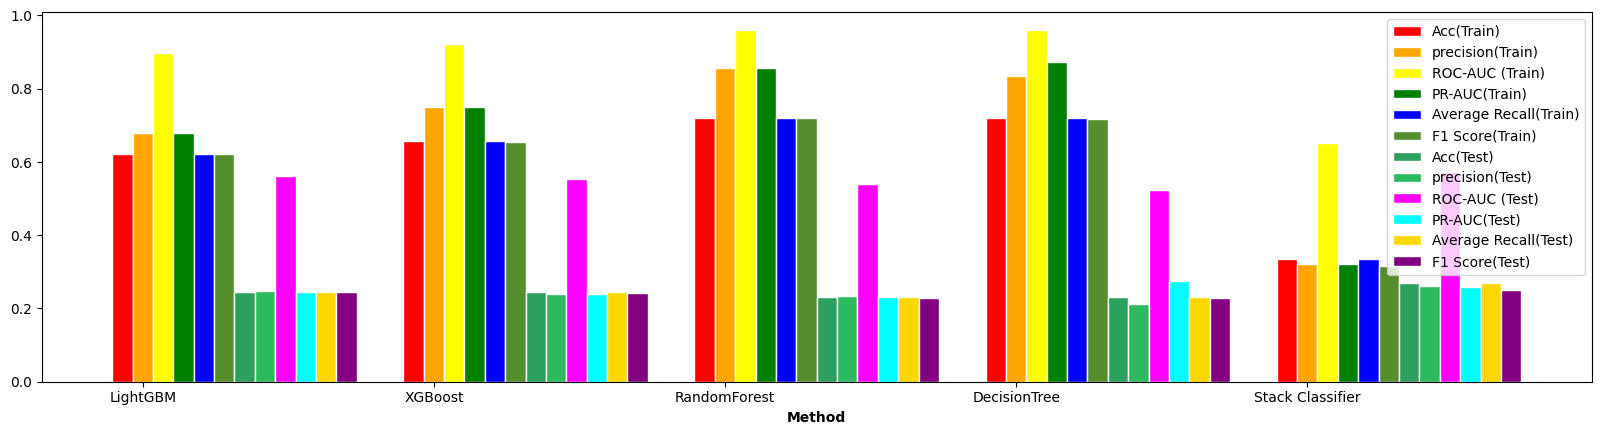

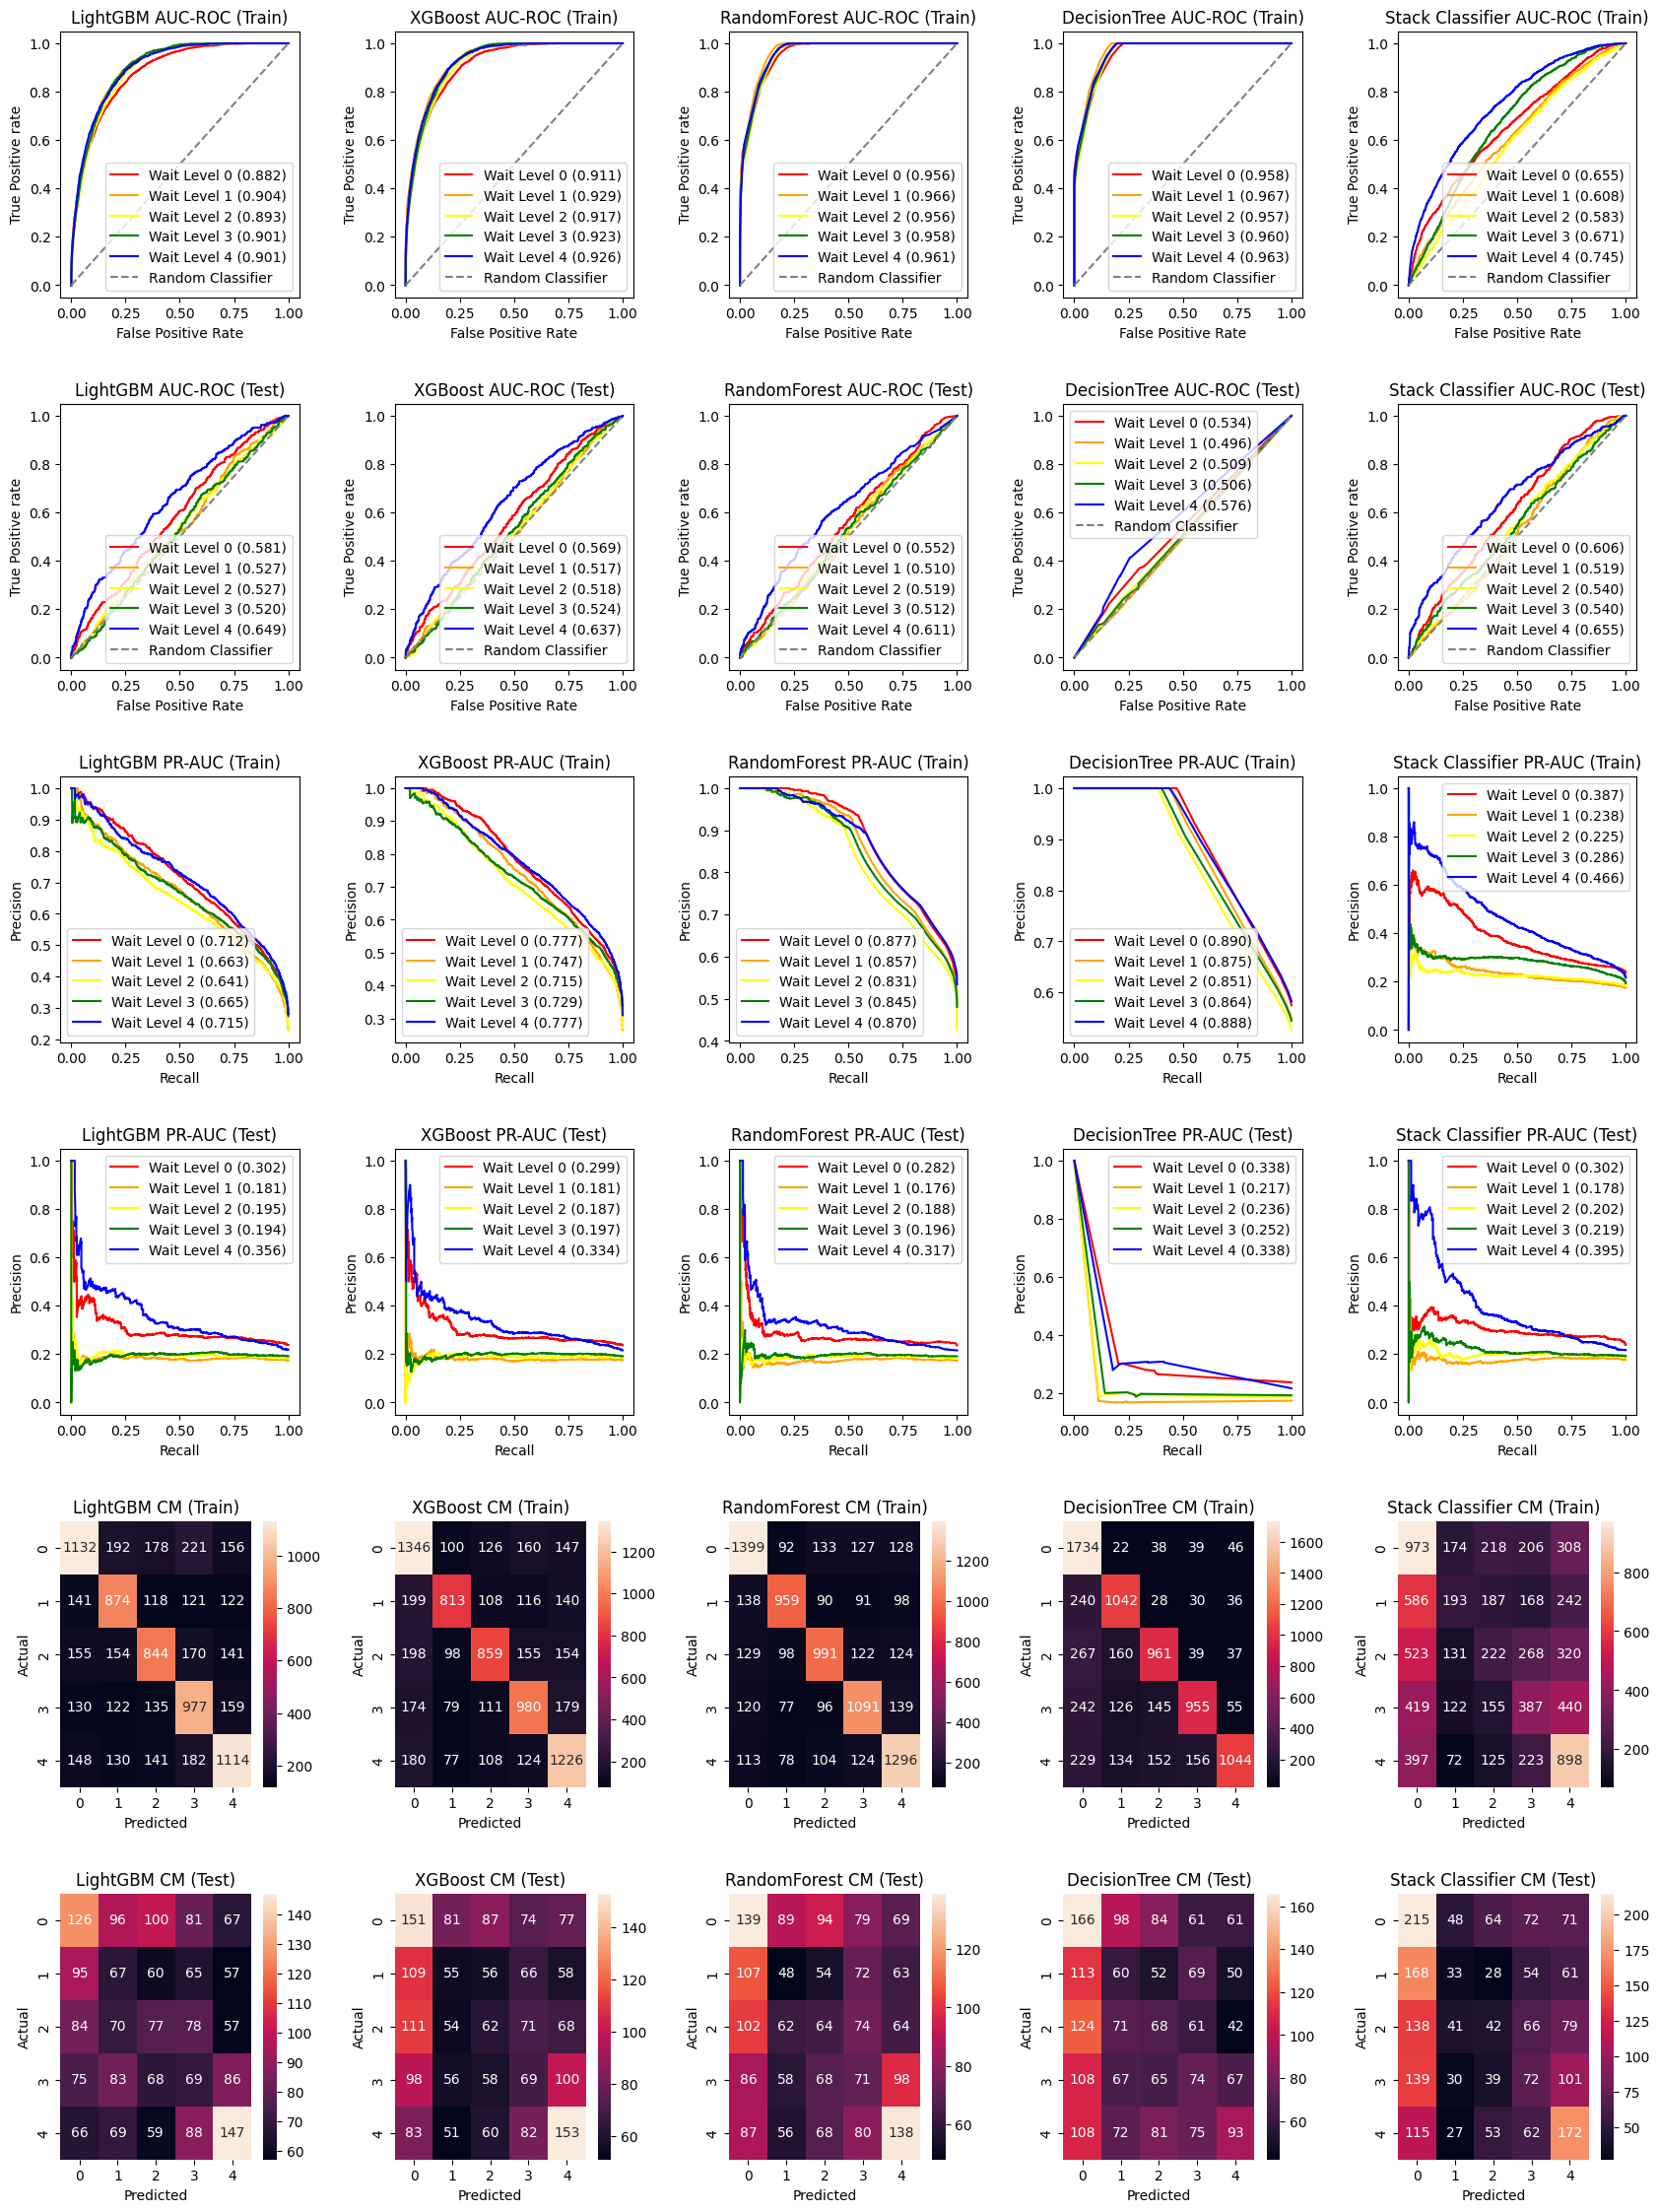

Summary Stats:


,LightGBM,XGBoost,RandomForest,DecisionTree,Stack Classifier
Acc(Train),0.620963,0.656529,0.720875,0.720875,0.335931
precision(Train),0.678955,0.748703,0.855886,0.835843,0.320812
ROC-AUC (Train),0.896282,0.921179,0.959415,0.961021,0.652281
PR-AUC(Train),0.679123,0.748890,0.856087,0.873752,0.320423
Average Recall(Train),0.620963,0.656529,0.720875,0.720875,0.335931
F1 Score(Train),0.621149,0.655411,0.720663,0.717993,0.314990
Acc(Test),0.244221,0.246231,0.231156,0.231658,0.268342
precision(Test),0.246787,0.240718,0.232813,0.212650,0.260924
ROC-AUC (Test),0.561039,0.552955,0.540800,0.524219,0.572200
PR-AUC(Test),0.245464,0.239638,0.231912,0.276059,0.259349


In [11]:
reload(CommonFunctions)
CommonFunctions.plotStackingGraph(preprocessingName, finalestimators, finalPipe, finalParam, X_train, y_train, X_test, y_test)

In [53]:
df = data[data[predict_col]<=2]
X_train, X_test, y_train, y_test = train_test_split(df.drop([predict_col,predict_col_src],axis=1, inplace=False), df[predict_col_src], test_size=0.2, random_state=0,stratify=df[predict_col])

In [54]:
estimators = [
    ("LightGBM", LGBMRegressor(objective='regression',random_state=0,n_jobs=-1,device = 'gpu')),
    ("ElasticNet", ElasticNet(random_state=0)),
    # ("XGBoost", XGBRegressor(objective='reg:squarederror',random_state=0,n_jobs=-1,use_label_encoder=False,  tree_method = 'gpu_hist')),#,eval_metric='r2'
    # ("RandomForest", RandomForestRegressor(random_state=0,n_jobs=-1)),
]
finalestimators = []
for estimator, model in estimators:
    finalestimators.append((estimator,pipeline.Pipeline([('columntransformer',data_preprocessor),('DropZeroCol',DropZeroCol()),(estimator,model)])))
final_estimator=LGBMRegressor(objective='regression',random_state=0,n_jobs=-1,device = 'gpu')
stacking_Regressor = StackingRegressor(estimators=estimators, final_estimator=final_estimator,n_jobs=-1)
finalPipe = pipeline.make_pipeline(data_preprocessor,DropZeroCol(),stacking_Regressor)
finalPipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   None),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   CreateDummyCol()),...
                                                                   ProcessWSpd(action='drop'))]),
                                                  ['tempt', 'prcp', 'wspd'])])),
                ('dropzerocol', DropZeroCol()),
                ('stackingregressor',
                 StackingRegressor(estimators=[('LightGBM',
                                                LGBMRegressor(device='gpu',
                                                              objective='regression',
                                                              random_state=0)),
                                               ('ElasticNet',
                                                ElasticNet(random_state=0))],
                                   final_estimator=LGBMRegressor(device='gpu',
                                                                 objective='regression',
                                                                 random_state=0),
                                   n_jobs=-1))])

In [55]:
param_grid = {
    ## ElasticNet hyper parameters
    'stackingregressor__ElasticNet__alpha': np.linspace(0, 1, num=10),
    'stackingregressor__ElasticNet__l1_ratio': np.linspace(0, 1, num=10),

    ## LGBM hyper parameters
    'stackingregressor__LightGBM__learning_rate': np.linspace(0.05, 0.5, num=4),
    'stackingregressor__LightGBM__max_depth': [3,5,7,10],
    'stackingregressor__LightGBM__n_estimators': [200,400,600,800],

    ## final estimator LGBM hyper parameters
    'final_estimator__learning_rate': np.linspace(0.05, 0.5, num=4),
    'final_estimator__max_depth': [3,5,7,10],
    'final_estimator__n_estimators': [200,400,600,800],

}
StackingRegressorParams = {}
regressorEstimatorsParam = {}
regressorFinalParam = {}

In [57]:
#tune hyperparameter

# regressorEstimatorsParam = {'stackingregressor__LightGBM__learning_rate': 0.05, 'stackingregressor__LightGBM__max_depth': 3, 'stackingregressor__LightGBM__n_estimators': 200, 'stackingregressor__ElasticNet__alpha': 0.8888888888888888, 'stackingregressor__ElasticNet__l1_ratio': 0.6666666666666666}
# regressorEstimatorsParam = {}
limitTuner = 'All' # Options All, ElasticNet, LightGBM ,None
preprocessingName = 'columntransformer__'
StackingRegressorName = 'stackingregressor__'
for estimator in finalestimators:
    if limitTuner== 'All' or estimator[0] ==limitTuner:
        modelParam = {}
        for param, grid in param_grid.items():
            if param.startswith(StackingRegressorName+estimator[0]):
                modelParam[param[len(StackingRegressorName):]] = grid
        for param, grid in preprocessingParam.items():
            modelParam[param] = [grid]
        # print(estimator[1].get_params().keys())
        print('\n\nTuning Model ',estimator[0], "with params:\n",  modelParam, '\n')
        gs = HalvingGridSearchCV(estimator=estimator[1],param_grid=modelParam,scoring = 'neg_root_mean_squared_error',n_jobs = -1,cv = 5,verbose = 10,min_resources=200)
        gs.fit(X_train,y_train)
        print('Tuned Model ',estimator[0], " (RMSE = ","{:.4f}".format(abs(gs.best_score_)),")")
        # print("Best params:\n",  gs.best_params_, '\n')
        modelParam={}
        for param, grid in gs.best_params_.items():
            if not param.startswith(preprocessingName):
                modelParam[StackingRegressorName+param] = grid
        regressorEstimatorsParam ={**regressorEstimatorsParam, **modelParam}


print('\n Params to use\n\n',regressorEstimatorsParam)



Tuning Model  LightGBM with params:
 {'LightGBM__learning_rate': array([0.05, 0.2 , 0.35, 0.5 ]), 'LightGBM__max_depth': [3, 5, 7, 10], 'LightGBM__n_estimators': [200, 400, 600, 800], 'columntransformer__date_linear_processor__ProcessDates': [ProcessDates()], 'columntransformer__date_linear_processor__ProcessHolidays': [None], 'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['dwt'], 'columntransformer__weather_linear_processor__ProcessWSpd__action': ['drop'], 'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual']} 

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 200
max_resources_: 4719
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 200
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 1
n_candidates: 22
n_resources: 600
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 2
n_candidates: 8
n_resources: 1800

In [60]:
# StackingRegressorParams = {'stackingregressor__final_estimator__learning_rate': 0.1}
StackingRegressorParams = {}
if len(StackingRegressorParams) == 0:
    # prepare data for final tuning
    finalPipe.set_params(**regressorEstimatorsParam,**preprocessingParam)
    finalTrain  = finalPipe.fit_transform(X_train,y_train)
    finalGrid = {}
    # generate final model params
    for param, grid in param_grid.items():
        if param.startswith(StackingRegressorParams+finalEstimatorName):
            finalGrid[param[len(StackingRegressorName+finalEstimatorName):]] = grid

    #tune final model
    print('\n\nTuning Model with params:\n',  finalGrid, '\n')
    gs = HalvingGridSearchCV(estimator=final_estimator,param_grid=finalGrid,scoring = CommonFunctions.roc_auc,n_jobs = -1,cv = 5,verbose = -1,min_resources=200)
    gs.fit(finalTrain,y_train)
    StackingClassifierParams = {}
    for param, grid in gs.best_params_.items():
        StackingRegressorParams[StackingRegressorName+finalEstimatorName+param] = grid
regressorFinalParam = {**preprocessingParam,**regressorEstimatorsParam, **StackingRegressorParams,}
regressorFinalParam

TypeError: unsupported operand type(s) for +: 'dict' and 'str'

In [47]:
finalPipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   None),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   CreateDummyCol()),...
                 StackingRegressor(estimators=[('LightGBM',
                                                LGBMClassifier(class_weight='balanced',
                                                               device='gpu',
                                                               learning_rate=0.05,
                                                               max_depth=3,
                                                               n_estimators=200,
                                                               objective='multiclass',
                                                               random_state=0)),
                                               ('ElasticNet',
                                                ElasticNet(alpha=0.3333333333333333,
                                                           l1_ratio=1.0,
                                                           random_state=0))],
                                   final_estimator=LGBMRegressor(device='gpu',
                                                                 objective='regression',
                                                                 random_state=0),
                                   n_jobs=-1))])

In [25]:
finalGrid

NameError: name 'finalGrid' is not defined

In [20]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
from sklearn.metrics import mean_squared_error
resultList = []
def ScoreArray(trainPredicted,testPredicted):
    trainrmse = math.sqrt(mean_squared_error(y_train, trainPredicted))
    trainr2 = r2_score(y_train, trainPredicted)
    mae = mean_absolute_error(y_test, testPredicted)
    rmse = math.sqrt(mean_squared_error(y_test, testPredicted))
    r2 = r2_score(y_test, testPredicted)
    return [trainrmse,trainr2,mae,rmse,r2]

finalPipe.set_params(**finalParam)
finalPipe.fit(X_train,y_train)
trainTrans = finalPipe.transform(X_train)
testTrans = finalPipe.transform(X_test)
i=0
for estimator in finalestimators:
    resultList.append((estimator[0],ScoreArray(trainTrans[:,i],testTrans[:,i])))
    i+=1
trainPredicted = finalPipe.predict(X_train)
testPredicted = finalPipe.predict(X_test)
resultList.append(("Stack Regressor",ScoreArray(trainPredicted,testPredicted)))

barWidth = 0.15

# set heights of bars
names = []
bars = [[],[],[],[],[]]
for name,result in resultList:
    names.append(name)
    bars[0].append(result[0])
    bars[1].append(result[1])
    bars[2].append(result[2])
    bars[3].append(result[3])
    bars[4].append(result[4])

# Set position of bar on X axis
r1 = np.arange(len(bars[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Make the plot
finalPlotLabels = ['RMSE(Train)','R2(Train)','MAE(Test)', 'RMSE(Test)', 'R2(Test)']
colours = ['#7f6d5f','#557f2d','#2d7f5e','#2d295e','#1d295e']
r = [r1,r2,r3,r4,r5]
i=0
for finalPlotLabel in finalPlotLabels:
    plt.bar(r[i], bars[i], color=colours[i], width=barWidth, edgecolor='white', label=finalPlotLabel)
    i+=1

# Add xticks on the middle of the group bars
plt.xlabel('Method', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[0]))], names)

# Create legend & Show graphic
plt.legend()
plt.show()

print(pd.DataFrame(bars,columns=names,index=finalPlotLabels))


ValueError: Invalid parameter stackingclassifier for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   None),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   CreateDummyCol()),...
                                                  ['tempt', 'prcp', 'wspd'])])),
                ('dropzerocol', DropZeroCol()),
                ('stackingregressor',
                 StackingRegressor(estimators=[('LightGBM',
                                                LGBMClassifier(class_weight='balanced',
                                                               device='gpu',
                                                               objective='multiclass',
                                                               random_state=0)),
                                               ('ElasticNet',
                                                ElasticNet(random_state=0))],
                                   final_estimator=LGBMRegressor(device='gpu',
                                                                 objective='regression',
                                                                 random_state=0),
                                   n_jobs=-1))]). Check the list of available parameters with `estimator.get_params().keys()`.